<a href="https://colab.research.google.com/github/Azaidi317/Segmentation-SAM/blob/main/Nuscenes_Sensor_projection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.781 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.


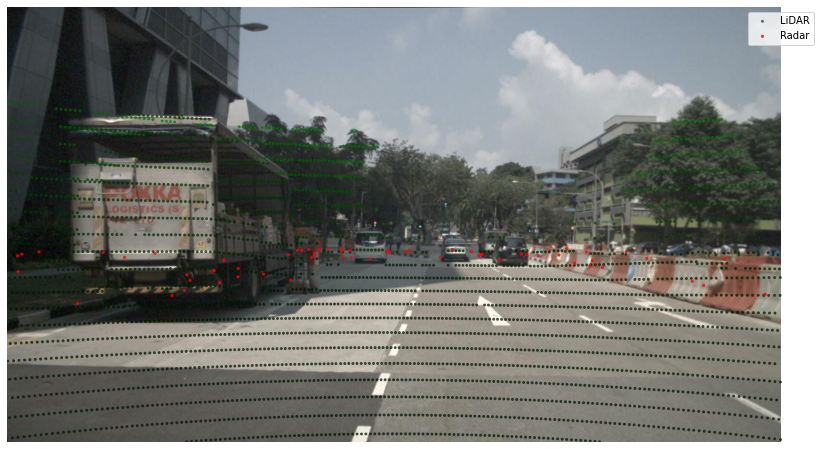

In [3]:
import numpy as np
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud
from nuscenes.utils.geometry_utils import view_points
import matplotlib.pyplot as plt
from pyquaternion import Quaternion

def load_sensor_data(nusc, sample):
    """
    Load camera, LiDAR, and radar data for a given sample.

    Args:
        nusc: NuScenes instance
        sample: Sample token or record

    Returns:
        camera_data: Camera image
        lidar_points: LiDAR point cloud
        radar_points: Radar point cloud
        cam_intrinsic: Camera intrinsic matrix
    """
    # Get camera data
    cam_token = sample['data']['CAM_FRONT']
    cam_data = nusc.get('sample_data', cam_token)
    camera_path = nusc.get_sample_data_path(cam_token)
    camera_data = plt.imread(camera_path)

    # Get camera calibration
    cam_intrinsic = np.array(nusc.get('calibrated_sensor',
                                     cam_data['calibrated_sensor_token'])['camera_intrinsic'])

    # Get LiDAR data
    lidar_token = sample['data']['LIDAR_TOP']
    lidar_path = nusc.get_sample_data_path(lidar_token)
    lidar_pc = LidarPointCloud.from_file(lidar_path)
    lidar_points = lidar_pc.points

    # Get radar data
    radar_token = sample['data']['RADAR_FRONT']
    radar_path = nusc.get_sample_data_path(radar_token)
    radar_pc = RadarPointCloud.from_file(radar_path)
    radar_points = radar_pc.points

    return camera_data, lidar_points, radar_points, cam_intrinsic

def transform_points_to_camera(points, from_sensor_token, to_sensor_token, nusc):
    """
    Transform points from one sensor's coordinate frame to another.

    Args:
        points: (4, N) points in source sensor coordinate frame
        from_sensor_token: Token of source sensor
        to_sensor_token: Token of target sensor
        nusc: NuScenes instance

    Returns:
        points_cam: (4, N) points in target sensor coordinate frame
    """
    # Get source sensor pose
    from_sensor = nusc.get('calibrated_sensor', from_sensor_token)
    from_pos = np.array(from_sensor['translation'])
    from_rot = Quaternion(from_sensor['rotation'])

    # Get target sensor pose
    to_sensor = nusc.get('calibrated_sensor', to_sensor_token)
    to_pos = np.array(to_sensor['translation'])
    to_rot = Quaternion(to_sensor['rotation'])

    # Transform points to vehicle frame
    points_vehicle = from_rot.rotation_matrix.dot(points[:3, :])
    points_vehicle += from_pos.reshape(3, 1)

    # Transform points to camera frame
    points_cam = np.linalg.inv(to_rot.rotation_matrix).dot(points_vehicle - to_pos.reshape(3, 1))

    return np.vstack((points_cam, points[3:]))

def project_points_to_image(points, cam_intrinsic, image_shape):
    """
    Project 3D points to 2D image plane.

    Args:
        points: (4, N) points in camera coordinate frame
        cam_intrinsic: (3, 3) camera intrinsic matrix
        image_shape: Tuple of (height, width)

    Returns:
        points_2d: (2, N) points in image coordinates
        mask: Boolean mask for points in front of camera and within image bounds
    """
    # Project points to image plane
    points_2d = view_points(points[:3, :], cam_intrinsic, normalize=True)

    # Create mask for points in front of camera and within image bounds
    mask = np.ones(points.shape[1], dtype=bool)
    mask = np.logical_and(mask, points[2, :] > 0)  # Points in front of camera
    mask = np.logical_and(mask, points_2d[0, :] > 0)
    mask = np.logical_and(mask, points_2d[1, :] > 0)
    mask = np.logical_and(mask, points_2d[0, :] < image_shape[1])
    mask = np.logical_and(mask, points_2d[1, :] < image_shape[0])

    return points_2d, mask

def visualize_fusion(camera_data, lidar_points_2d, radar_points_2d,
                    lidar_mask, radar_mask, lidar_colors=None, radar_colors=None):
    """
    Visualize sensor fusion by overlaying point clouds on camera image.

    Args:
        camera_data: Camera image
        lidar_points_2d: (2, N) LiDAR points in image coordinates
        radar_points_2d: (2, N) radar points in image coordinates
        lidar_mask: Boolean mask for valid LiDAR points
        radar_mask: Boolean mask for valid radar points
        lidar_colors: Colors for LiDAR points (optional)
        radar_colors: Colors for radar points (optional)
    """
    plt.figure(figsize=(15, 8))
    plt.imshow(camera_data)

    # Plot LiDAR points
    if lidar_colors is None:
        lidar_colors = np.ones((lidar_points_2d.shape[1], 3)) * [0, 1, 0]  # Green
    plt.scatter(lidar_points_2d[0, lidar_mask],
               lidar_points_2d[1, lidar_mask],
               c=lidar_colors[lidar_mask],
               s=4,
               alpha=0.6,
               label='LiDAR')

    # Plot radar points
    if radar_colors is None:
        radar_colors = np.ones((radar_points_2d.shape[1], 3)) * [1, 0, 0]  # Red
    plt.scatter(radar_points_2d[0, radar_mask],
               radar_points_2d[1, radar_mask],
               c=radar_colors[radar_mask],
               s=5,
               alpha=0.7,
               label='Radar')

    plt.legend()
    plt.axis('off')
    plt.show()

def main():
    """
    Main function to demonstrate sensor fusion visualization.
    """
    # Initialize NuScenes
    nusc = NuScenes(version='v1.0-mini',
                    dataroot="/users/azaidi/Downloads/v1.0-mini 2",
                    verbose=True)

    # Get a sample
    sample = nusc.sample[0]

    # Load sensor data
    camera_data, lidar_points, radar_points, cam_intrinsic = load_sensor_data(nusc, sample)

    # Get sensor tokens
    cam_token = nusc.get('sample_data', sample['data']['CAM_FRONT'])['calibrated_sensor_token']
    lidar_token = nusc.get('sample_data', sample['data']['LIDAR_TOP'])['calibrated_sensor_token']
    radar_token = nusc.get('sample_data', sample['data']['RADAR_FRONT'])['calibrated_sensor_token']

    # Transform points to camera frame
    lidar_points_cam = transform_points_to_camera(lidar_points, lidar_token, cam_token, nusc)
    radar_points_cam = transform_points_to_camera(radar_points, radar_token, cam_token, nusc)

    # Project points to image plane
    lidar_points_2d, lidar_mask = project_points_to_image(lidar_points_cam,
                                                         cam_intrinsic,
                                                         camera_data.shape[:2])
    radar_points_2d, radar_mask = project_points_to_image(radar_points_cam,
                                                         cam_intrinsic,
                                                         camera_data.shape[:2])

    # Color LiDAR points by height
    lidar_colors = np.zeros((lidar_points.shape[1], 3))
    normalized_height = (lidar_points[2, :] - lidar_points[2, :].min()) / \
                       (lidar_points[2, :].max() - lidar_points[2, :].min())
    lidar_colors[:, 1] = normalized_height  # Green channel varies with height

    # Color radar points by velocity
    radar_colors = np.zeros((radar_points.shape[1], 3))
    radar_colors[:, 0] = 1  # Red for radar points

    # Visualize fusion
    visualize_fusion(camera_data,
                    lidar_points_2d,
                    radar_points_2d,
                    lidar_mask,
                    radar_mask,
                    lidar_colors,
                    radar_colors)

if __name__ == '__main__':
    main()